# 用随机梯度法求解 MNIST 上的多项逻辑回归问题（无 ML 框架）

作者：Jed

来源：https://www.jeddd.com/article/use-python-to-solve-softmax-regression-on-mnist-by-sgd

时间：2019年6月

---

## 准备工作

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numba

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# 读取数据
import gzip
def read_idx3(filename):
    with gzip.open(filename, 'rb') as fo:
        buf = fo.read()
        index = 0
        header = np.frombuffer(buf, '>i', 4, index)
        index += header.size * header.itemsize
        data = np.frombuffer(buf, '>B', header[1] * header[2] * header[3], index).reshape(header[1], -1)
        return data
    
def read_idx1(filename):
    with gzip.open(filename, 'rb') as fo:
        buf = fo.read()
        index = 0
        header = np.frombuffer(buf, '>i', 2, index)
        index += header.size * header.itemsize
        data = np.frombuffer(buf, '>B', header[1], index)
        return data

data_path = 'MNIST_data/'

X_train = read_idx3(data_path + 'train-images-idx3-ubyte.gz')  # 训练数据集的样本特征
y_train = read_idx1(data_path + 'train-labels-idx1-ubyte.gz')  # 训练数据集的标签
X_test = read_idx3(data_path + 't10k-images-idx3-ubyte.gz')  # 测试数据集的样本特征
y_test = read_idx1(data_path + 't10k-labels-idx1-ubyte.gz')  # 测试数据集的标签

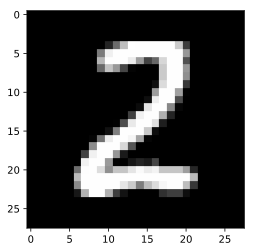

Index: 32989; Label: 2


In [3]:
# 随机选一个数据观察
example_idx = np.random.randint(len(X_train))  # 随机选取的样本编号
# example_idx = 4221
plt.imshow(np.reshape(X_train[example_idx], (28, 28)), cmap='gray')
plt.show()
print('Index: {}; Label: {}'.format(example_idx, y_train[example_idx]))

In [4]:
# 定义常量
x_dim = 28 * 28  # 输入维度
y_dim = 10       # 输出维度
W_dim = (y_dim, x_dim)  # 权重矩阵参数的维度
b_dim = y_dim           # 偏置向量参数的维度

## 定义若干函数

In [5]:
# Softmax函数
def softmax(x):
    """
    计算向量z的softmax函数值，返回值维度与z相同。
    """
    x_shifted = x - np.max(x)  # 防止溢出为nan
    return np.exp(x_shifted) / np.exp(x_shifted).sum()

In [6]:
# 损失函数
# 注：该函数在实验中没有实际作用，仅用于帮助理解损失函数的表达式
# def loss(W, b, x, y):
#     """
#     W, b为当前的权重参数和偏置参数，x为一个样本特征，y为x对应的标签。
#     """
#     y_pred = W @ x + b
#     return -np.log(softmax(y_pred)[y])  # 预测值与标签相同的概率


# 损失函数的梯度
@numba.jit
def loss_gradient(W, b, x, y):
    """
    W和b为当前的参数，x为一个样本，y为x对应的标签。
    """
    W_gradient = np.zeros(W.shape)
    b_gradient = np.zeros(b.shape)
    sm = softmax(W @ x + b)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if y == i:
                W_gradient[i][j] = (sm[i] - 1) * x[j]
            else:
                W_gradient[i][j] = sm[i] * x[j]
                
    for i in range(b.shape[0]):
        if y == i:
            b_gradient[i] = sm[i] - 1
        else:
            b_gradient[i] = sm[i]
    return W_gradient, b_gradient

In [7]:
# 模型评估函数
def score(W, b, X_test, y_test):
    """
    W和b为待评估的模型参数，x_test和y_test为测试数据集的特征和标签
    """
    assert len(X_test) == len(y_test)
    
    tests_num = len(X_test)  # 测试集的大小
    results = []             # 保存每个测试的结果，0为错误预测；1为正确预测
    for i in range(tests_num):
        y_pred = W @ X_test[i] + b  # 预测结果
        sm = softmax(y_pred)
        results.append(sm.argmax() == y_test[i])
    return np.mean(results)  # 返回分类精度

## 随机梯度下降

In [8]:
W = np.zeros(W_dim)  # W的初值
b = np.zeros(b_dim)  # b的初值

# mini-batch随机梯度下降
def msgd(alpha, batch_size, epochsnum):
    global W, b
    W = np.zeros(W_dim)  # 清零，避免上次运行结果的影响
    b = np.zeros(b_dim)  # 清零
    
    # batches_x和batches_y分别是将原样本和标签按batch分批后的结果
    batches_x = np.array([X_train[i:i+batch_size] for i in range(0, X_train.shape[0], batch_size)])
    batches_y = np.array([y_train[i:i+batch_size] for i in range(0, y_train.shape[0], batch_size)])

    batches_num = batches_x.shape[0]  # batch的总数量
    plot_scores = []  # 记录每次迭代的分类精度
    plot_iter_W = []  # 记录每次迭代的参数W
    plot_iter_b = []  # 记录每次迭代的参数b

#     print('Train set size:', X_train.shape[0])
#     print('Mini-batch size:', batch_size)
#     print('Batches number:', batches_num)
    print('Start training...')

    time_start = time.time()  # 开始计时

    for epoch in range(epochs_num):
        for i in range(batches_num):
            batch_x = batches_x[i]
            batch_y = batches_y[i]
            W_gradient = np.zeros(W_dim)
            b_gradient = np.zeros(b_dim)
            for j in range(batch_size):
                gradients = loss_gradient(W, b, batch_x[j], batch_y[j])
                W_gradient += gradients[0]
                b_gradient += gradients[1]
            W_gradient /= batch_size  # 该batch的平均梯度
            b_gradient /= batch_size  # 该batch的平均梯度

            W -= alpha * W_gradient
            b -= alpha * b_gradient
            
            current_score = score(W, b, X_test, y_test)
            plot_scores.append(current_score)  # 记录每次迭代的分类精度
            plot_iter_W.append(W.copy())
            plot_iter_b.append(b.copy())
#             if i % 100 == 0:
#                 print('Batch', i, 'Score:', current_score)  # 每100个batch打印一条提示信息

#         print('Epoch', epoch)

    time_end = time.time()  # 结束计时
    return (time_end - time_start), plot_scores, plot_iter_W, plot_iter_b

Start training...
Alpha:1e-05; Batch_size:1000; Epochs_num:10; Time cost:135.68 s; Accuracy:91.95%.


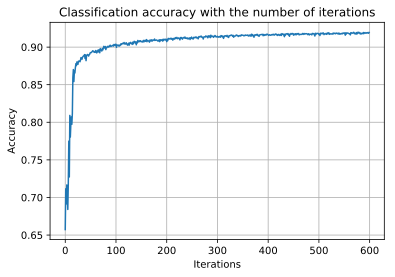

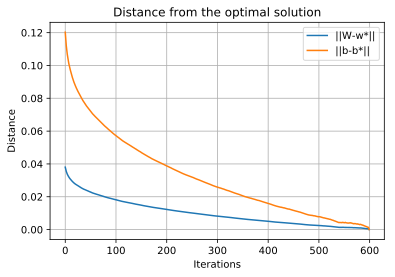

In [9]:
arg_list = [(1e-5, 1000, 10),
           ]

for arg in arg_list:
    alpha = arg[0]
    batch_size = arg[1]
    epochs_num = arg[2]

    result = msgd(alpha, batch_size, epochs_num)
    time_cost = result[0]
    plot_scores = result[1]
    plot_iter_W = result[2]
    plot_iter_b = result[3]
    print('Alpha:{}; Batch_size:{}; Epochs_num:{}; Time cost:{:.2f} s; Accuracy:{:.2%}.'
          .format(alpha, batch_size, epochs_num, time_cost, plot_scores[-1]))

    for i in range(len(plot_iter_W)):
        plot_iter_W[i] = np.linalg.norm(plot_iter_W[i] - W)
        plot_iter_b[i] = np.linalg.norm(plot_iter_W[i] - b)

    # 作图
    plt.title('Classification accuracy with the number of iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.plot(plot_scores)
    plt.grid()
    plt.savefig(str(batch_size)+'_1.svg')
    plt.show()

    plt.title('Distance from the optimal solution')
    plt.xlabel('Iterations')
    plt.ylabel('Distance')
    plt.plot(plot_iter_W, label='||W-w*||')
    plt.plot(plot_iter_b, label='||b-b*||')
    plt.legend()
    plt.grid()
    plt.savefig(str(batch_size)+'_2.svg')
    plt.show()

In [10]:
print(W)
print(b)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[-6.19853360e-06  6.94547322e-06  2.20740170e-06 -5.36776685e-06
  1.36657366e-06  2.59711614e-05 -1.24314695e-06  1.08946752e-05
 -3.03490069e-05 -4.22683084e-06]


## 评估模型

In [11]:
# 模型在测试数据集上的分类精度
score(W, b, X_test, y_test)

0.9195

---

作者：Jed

来源：https://www.jeddd.com/article/use-python-to-solve-softmax-regression-on-mnist-by-sgd